In [1]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import seaborn as sns
import random
import scipy
from scipy.stats import chi2


In [6]:
# Read the data
df_clinical = pd.read_csv('data/pcawg_donor_clinical_August2016_v9.csv', sep='\t')

df_TGA = pd.read_excel('data/TCGA-CDR-SupplementalTableS1.xlsx')
df_TGA = df_TGA.rename(columns={'bcr_patient_barcode': 'submitted_donor_id'})

df_design = pd.read_csv('data/PCAWG_experiment-design.tsv', sep='\t')
df_design = df_design.rename(columns={'Sample Characteristic[individual]': 'icgc_donor_id'})

# Merge the three data frames
df = pd.merge(df_TGA, df_clinical, on="submitted_donor_id")
df = pd.merge(df, df_design, on='icgc_donor_id')

# Filter by cancer type
# df=df[df['type']=='BRCA']

# Formatting the gender: FEMALE -> 0, MALE -> 1
df['gender'] = df['gender'].replace(to_replace='FEMALE', value=0)
df['gender'] = df['gender'].replace(to_replace='MALE', value=1)

# Removing NA's
df['OS.time'] = df['OS.time'].fillna(0) # 3 NA's
df['age_at_initial_pathologic_diagnosis'] = df['age_at_initial_pathologic_diagnosis'].fillna(0) # 4 NA's

/tmp/ipykernel_71853/1072912563.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(to_replace='MALE', value=1)


In [7]:
res = pd.read_csv('/home/raul/Documents/projects/TAFI/results/all_PCAWG.csv')

# Predict model: 2 if WF wins, else 1
res['predicted_model'] = np.where(res['score_WF'] > res['score_EXP'], 2, 1)

df_wf = res[res['predicted_model'] == 1].copy()
df_exp = res[res['predicted_model'] == 2].copy()
df_wf['predicted_C'] = df_wf['C_WF']
df_exp['predicted_C'] = df_exp['C_EXP']
df_wf['predicted_S'] = df_wf['S_WF']
df_exp['predicted_S'] = df_exp['S_EXP']
df_wf['predicted_pur'] = df_wf['pur_WF']
df_exp['predicted_pur'] = df_exp['pur_EXP']

res = pd.concat([df_wf, df_exp], axis=0)

res['donor_short'] = res['donor'].str.split('_').str[1]
df = pd.merge(df, res, left_on='icgc_donor_id', right_on='donor_short', how='inner')

df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage I', value=1)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IA', value=1)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IB', value=1)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage II', value=2)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IIA', value=2)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IIB', value=2)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage III', value=3)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IIIA', value=3)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IIIB', value=3)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IIIC', value=3)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IV', value=4)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IVA', value=4)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IVB', value=4)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='Stage IVC', value=4)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='[Not Available]', value=0)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='[Not Applicable]', value=0)
df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='[Discrepancy]', value=0)

/tmp/ipykernel_71853/3057936555.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ajcc_pathologic_tumor_stage'] = df['ajcc_pathologic_tumor_stage'].replace(to_replace='[Discrepancy]', value=0)


In [8]:
# Reduced data frame with the desired parameters
cox_df=df[['age_at_initial_pathologic_diagnosis', 'ajcc_pathologic_tumor_stage' ,'OS.time','gender','OS', 'predicted_model', 'type']]

cox_df = pd.get_dummies(cox_df, columns=['type'], drop_first=True)


# Fitting the model and printing the results
cph = CoxPHFitter()
cph.fit(cox_df, duration_col = 'OS.time', event_col='OS')
cph.print_summary()

/home/raul/miniconda3/lib/python3.11/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column type_DLBC have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'type_DLBC'].var())
>>> print(df.loc[~events, 'type_DLBC'].var())

A very low variance means that the column type_DLBC completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/raul/miniconda3/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.175. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity 

<lifelines.CoxPHFitter: fitted with 349 total observations, 227 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 349
number of events observed = 122
   partial log-likelihood = -555.67
         time fit was run = 2025-05-21 10:55:47 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
age_at_initial_pathologic_diagnosis   0.02      1.02      0.01            0.00            0.04                1.00                1.04
ajcc_pathologic_tumor_stage           0.78      2.19      0.13            0.52            1.05                1.68                2.85
gender                                0.38      1.46      0.24           -0.10            0.85                0.91                2.35
predicted_model                      -0.03      0.97      0.30           -0.61            0.55                0.54                1.74
type_BRCA                            -0.21      0.81      0.69           -1.56            1.14                0.21                3.13
type_CESC                             3.18     23.96      0.89            1.44            4.91                4.23              135.91
type_COAD                             0.21      1.24      0.70           -1.16            1.59                0.31                4.92
type_DLBC                           -14.95      0.00   8364.44       -16408.94        16379.05                0.00                 inf
type_GBM                              3.87     47.76      0.79            2.33            5.41               10.24              222.83
type_HNSC                            -0.50      0.61      0.69           -1.85            0.85                0.16                2.33
type_KICH                            -2.09      0.12      1.14           -4.33            0.14                0.01                1.15
type_KIRC                            -0.08      0.92      0.61           -1.27            1.12                0.28                3.06
type_KIRP                             0.90      2.46      0.93           -0.91            2.71                0.40               15.06
type_LGG                              2.53     12.51      0.88            0.79            4.26                2.21               70.85
type_LIHC                             0.39      1.48      0.66           -0.90            1.69                0.40                5.42
type_LUAD                             0.84      2.32      0.61           -0.35            2.03                0.70                7.63
type_LUSC                             0.52      1.68      0.73           -0.92            1.96                0.40                7.07
type_OV                               1.29      3.64      1.24           -1.14            3.72                0.32               41.43
type_PRAD                           -15.11      0.00   2463.79        -4844.04         4813.82                0.00                 inf
type_READ                             0.86      2.35      1.18           -1.45            3.16                0.23               23.62
type_SARC                             1.99      7.30      0.82            0.38            3.60                1.46               36.42
type_SKCM                             0.55      1.74      0.62           -0.66            1.76                0.52                5.84
type_STAD                             0.15      1.17      0.81           -1.43            1.74                0.24                5.67
type_THCA                            -1.08      0.34      0.69           -2.44            0.27                0.09                1.31
type_UCEC                             1.58      4.88      0.80            0.02            3.15                1.02               23.3

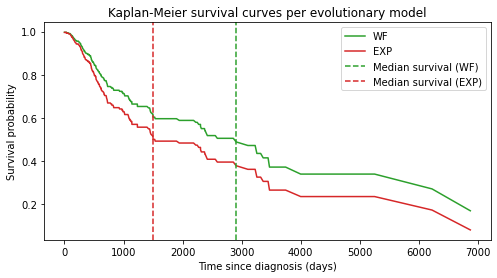

In [32]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines import KaplanMeierFitter

class_wf = cph.predict_survival_function(cox_df[cox_df['predicted_model'] == 1]).mean(axis=1)

class_exp = cph.predict_survival_function(cox_df[cox_df['predicted_model'] == 2]).mean(axis=1)

# Plot survival probability
plt.figure(figsize=(8, 4))
plt.plot(class_wf.index, class_wf.values, label='WF', color='tab:green')
plt.plot(class_exp.index, class_exp.values, label='EXP', color='tab:red')
plt.axvline(median_survival_times(class_wf), linestyle='--', color='tab:green', label='Median survival (WF)')
plt.axvline(median_survival_times(class_exp), linestyle='--', color='tab:red', label='Median survival (EXP)')
plt.xlabel('Time since diagnosis (days)')
plt.ylabel('Survival probability')
plt.title('Kaplan-Meier survival curves per evolutionary model')
plt.legend()
plt.show()